In [1]:
import keras
import tensorflow

from keras import layers
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, Cropping2D, GlobalAveragePooling2D
from keras.layers import Input, Flatten, Dropout, Dense ,Activation, BatchNormalization, Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.preprocessing.image_preprocessing import RandomCrop
from keras import regularizers
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, SGD
from keras.initializers import GlorotNormal, HeNormal
from keras.callbacks import ModelCheckpoint, EarlyStopping

import datetime
import time

import json
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
batch_size = 128

fer2013_path = '/kaggle/input/fer2013/'
ckplus_path =  '/kaggle/input/ckplus/CK+48/'
rafdb_path = '/kaggle/input/raf-db/aligned/'
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
emotions = ['angry', 'disgust', 'fear','happy', 'neutral', 'sad', 'surprise']
emotions_dict = {'0': 'angry', '1': 'disgust', '2': 'fear', '3': 'happy', 
                '4': 'neutral', '5': 'sad', '6': 'surprise'}

In [3]:
fer_emotions = {'0': 'angry', 
                '1': 'disgust', 
                '2': 'fear', 
                '3': 'happy', 
                '4': 'neutral', 
                '5': 'sad', 
                '6': 'surprise'}

raf_emotions = {1: 'Surprise',
                2: 'Fear',
                3: 'Disgust',
                4: 'Happiness',
                5: 'Sadness',
                6: 'Anger',
                7: 'Neutral'}

In [4]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,   # 旋转角度数范围
                                   width_shift_range=0.2,   # 宽度偏移量
                                   height_shift_range=0.2,   # 高度偏移量
                                   shear_range=0.2,   # 随机错切
                                   zoom_range=0.2,   # 随机缩放图
                                   horizontal_flip=True,   # 随机水平翻转
                                   fill_mode='nearest')

datagen_val = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = datagen_train.flow_from_directory(rafdb_path + "train",
                                                    target_size=(100,100),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = datagen_val.flow_from_directory(rafdb_path + "test",
                                                target_size=(100,100),
                                                color_mode="rgb",
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=False)

Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


In [6]:
vgg19 = tensorflow.keras.applications.VGG19(
                    include_top=False,
                    weights="imagenet",
                    input_tensor=None,
                    input_shape=(100,100,3),
                    pooling=None,
                    classes=7
)

80134624/80134624 [==============================] - 0s 0us/step


In [7]:
x = vgg19.output

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64,activation='relu')(x)
output = Dense(7,activation='softmax')(x)

vgg = Model(inputs=vgg19.input,outputs=output)

In [8]:
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

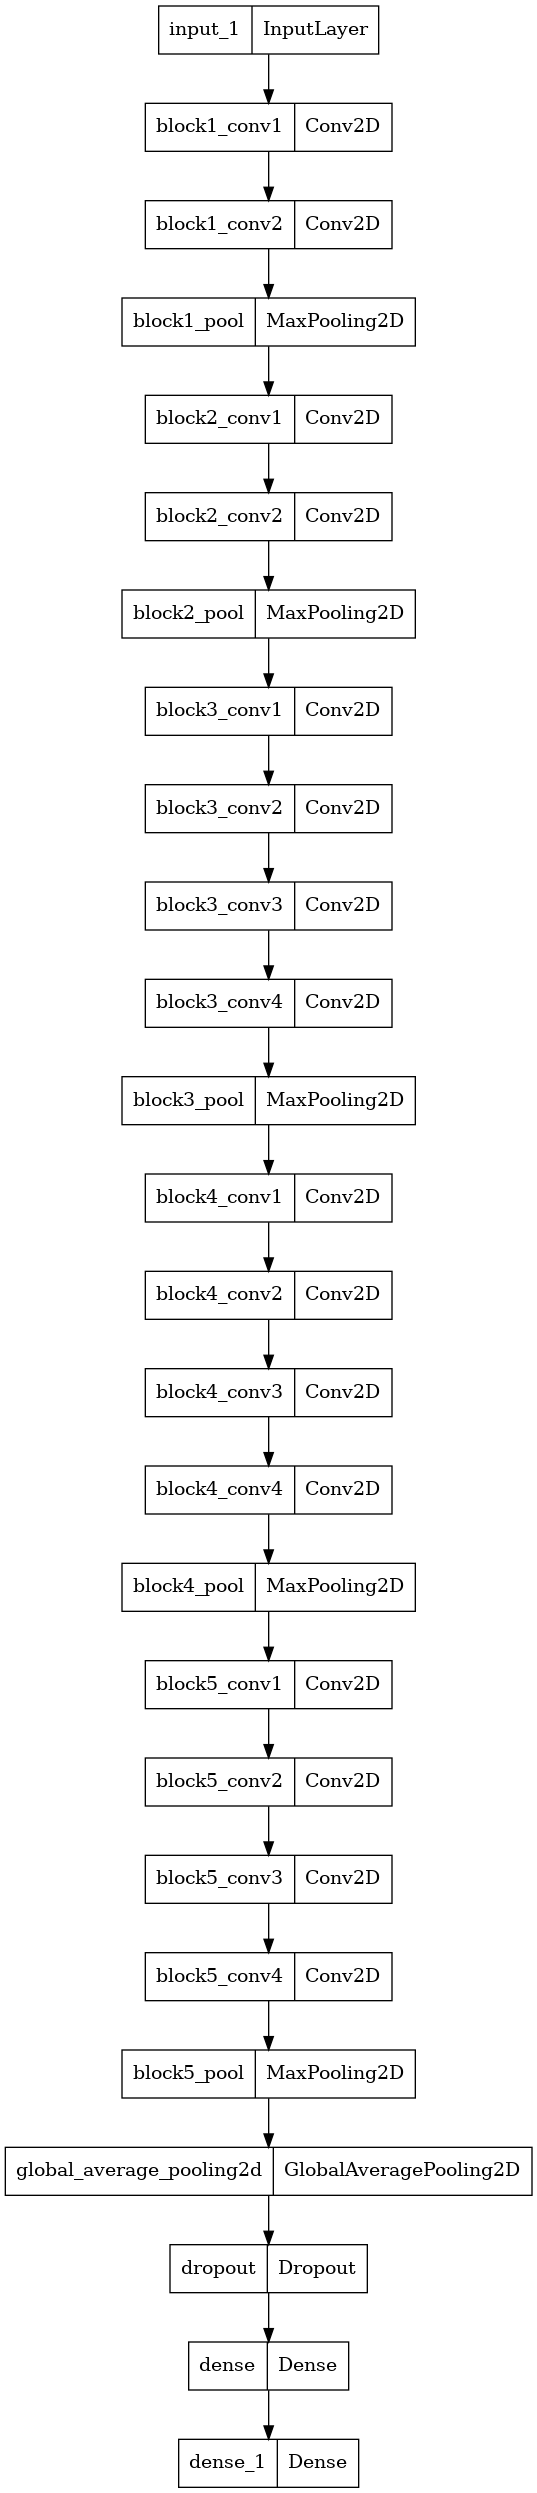

In [9]:
keras.utils.plot_model(vgg)

In [10]:
opt = Adam(learning_rate=0.0001)
vgg.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model_checkpoint_callback = ModelCheckpoint(
                                filepath = f'vgg19_checkpoint/{current_time}/'+'{epoch:02d}-{' + 'val_accuracy' + ':.5f}.hdf5',
                                save_weights_only=False,
                                verbose = 1,
                                monitor = 'val_accuracy',
                                mode='auto',
                                period = 10,
                                save_best_only=True)

early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=30, mode='max', verbose=1, restore_best_weights = True)

In [12]:
history = vgg.fit(x=train_generator,
                    epochs=100,
                    validation_data = val_generator,
                    callbacks=[model_checkpoint_callback, early_stop]) 

Epoch 1/100
96/96 [==============================] - 111s 981ms/step - loss: 1.5745 - accuracy: 0.4132 - val_loss: 1.1996 - val_accuracy: 0.5668
Epoch 2/100
96/96 [==============================] - 61s 629ms/step - loss: 1.1463 - accuracy: 0.5943 - val_loss: 0.8324 - val_accuracy: 0.7128
Epoch 3/100
96/96 [==============================] - 62s 642ms/step - loss: 0.9498 - accuracy: 0.6704 - val_loss: 0.7668 - val_accuracy: 0.7288
Epoch 4/100
96/96 [==============================] - 62s 646ms/step - loss: 0.8201 - accuracy: 0.7158 - val_loss: 0.7548 - val_accuracy: 0.7370
Epoch 5/100
96/96 [==============================] - 61s 629ms/step - loss: 0.7326 - accuracy: 0.7446 - val_loss: 0.6533 - val_accuracy: 0.7705
Epoch 6/100
96/96 [==============================] - 60s 626ms/step - loss: 0.6781 - accuracy: 0.7607 - val_loss: 0.5862 - val_accuracy: 0.8002
Epoch 7/100
96/96 [==============================] - 61s 631ms/step - loss: 0.6586 - accuracy: 0.7688 - val_loss: 0.6974 - val_accuracy

In [13]:
with open('vgg19_rafdb_history.json', 'w') as f:
    json.dump(history.history, f)

In [20]:
vgg.evaluate(val_generator)

24/24 [==============================] - 4s 171ms/step - loss: 0.4789 - accuracy: 0.8550


[0.4788969159126282, 0.8549543619155884]

<AxesSubplot:>

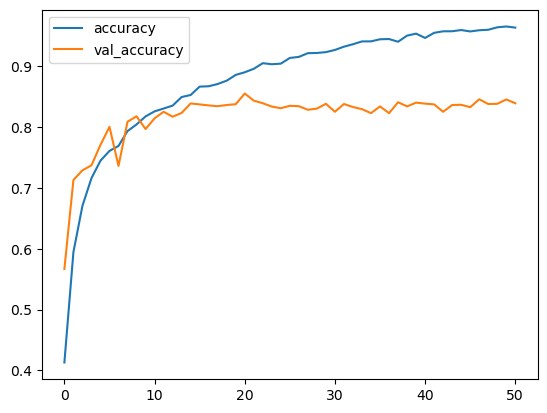

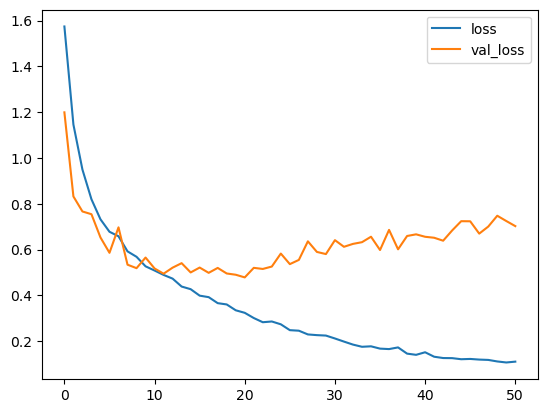

In [14]:
h = history.history.copy()
del h['loss']
del h['val_loss']
pd.DataFrame(h).plot()

h = history.history.copy()
del h['accuracy']
del h['val_accuracy']
pd.DataFrame(h).plot()

24/24 [==============================] - 4s 163ms/step


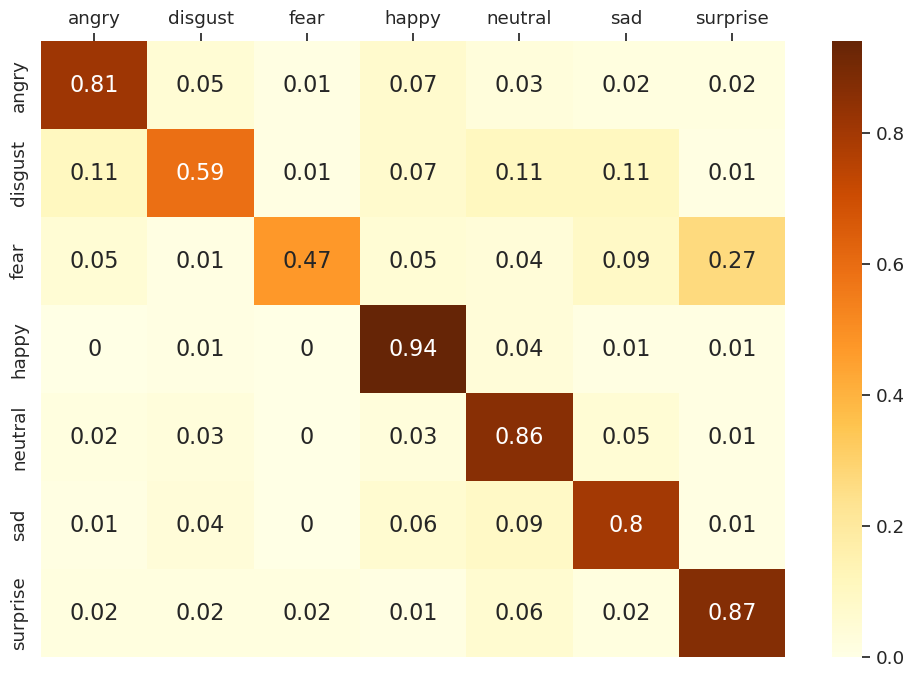

In [46]:
# model = load_model('')
pred = vgg.predict(val_generator).argmax(axis=-1)
labels = val_generator.labels

fer_matrix = confusion_matrix(labels, pred)
fer_matrix_norm = fer_matrix.astype('float') / fer_matrix.sum(axis=1)[:, np.newaxis]     
fer_matrix_norm = np.around(fer_matrix_norm, decimals=2)

def plot_confusion_matrix(confusion_matrix,emotions_dictionary,ax=None):
    df_fm = pd.DataFrame(confusion_matrix, index = emotions_dictionary.values(),
                         columns = emotions_dictionary.values())
    sns.set(font_scale=1.2) 
    ax = sns.heatmap(df_fm, annot=True,annot_kws={"size": 16},cmap='YlOrBr')
    ax.xaxis.set_ticks_position('top')

fig,ax = plt.subplots(figsize=(12,8))
plot_confusion_matrix(fer_matrix_norm,emotions_dict,ax=ax)

In [15]:
import os
for dir, _, files in os.walk('/kaggle/working/vgg19_checkpoint/20230301-151109'):
    for file in files:
        print(file)

20-0.83735.hdf5
40-0.83996.hdf5
10-0.79661.hdf5
30-0.83801.hdf5
50-0.84518.hdf5


In [22]:
m = load_model('/kaggle/working/vgg19_checkpoint/20230301-151109/50-0.84518.hdf5')
m.save('50-0.84518.hdf5')

In [25]:
from IPython.display import FileLink
FileLink('50-0.84518.hdf5')

/kaggle/working/50-0.84518.hdf5

In [26]:
import cv2
import numpy as np
face_cascade = cv2.CascadeClassifier('/kaggle/input/modelfile/haarcascade_frontalface_alt2.xml')

In [44]:
img = cv2.imread('/kaggle/input/local-fer2013/surprisehappy.png')
img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

face = face_cascade.detectMultiScale(img, scaleFactor=1.2, minNeighbors=10)
x, y, w, h = 0, 0, 0, 0
for (x, y, w, h) in face:
    x, y, w, h = x, y, w, h
if x == 0 and w ==0:
    print('no face detected')
    img_100 = cv2.resize(img, (100, 100))
else:
    print('face detected')
    img_100 = cv2.resize(img[y:y + h, x:x + w], (100, 100))
    
img_input = img_100.reshape(1, 100, 100, 3)
pred = vgg.predict(img_input)
print(emotions[np.argmax(pred)])

face detected
1/1 [==============================] - 0s 22ms/step
surprise
